In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


In [ ]:
BATCH_SIZE = 32
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


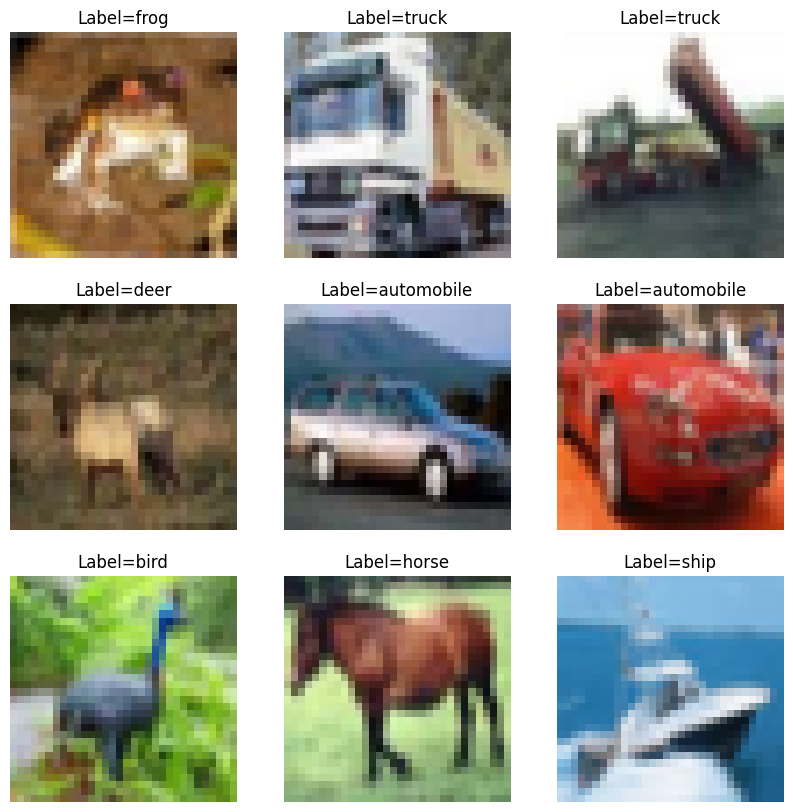

In [ ]:
# Create a subplot
plt.figure(figsize=(10, 10))
for i in range(9):
      # Display the image
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(training_images[i], cmap='gray')
      # Print the label
      plt.title("Label="+label_names[ training_labels[i][0]])
      plt.axis('off')

# Show the subplot
plt.show()

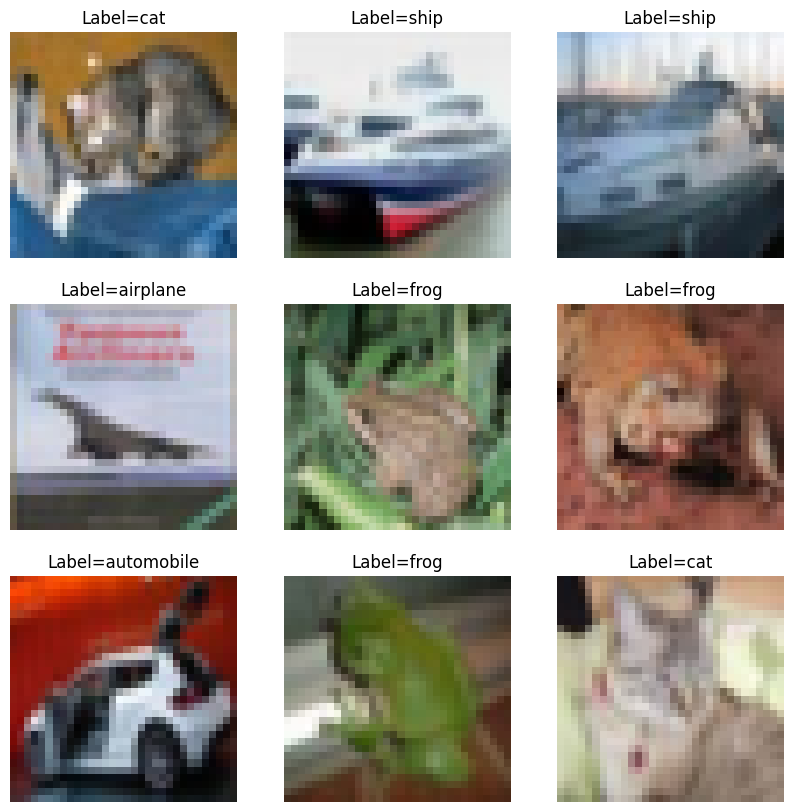

In [ ]:
# Create a subplot
plt.figure(figsize=(10, 10))
for i in range(9):
      # Display the image
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(validation_images[i], cmap='gray')
      # Print the label
      plt.title("Label="+label_names[ validation_labels[i][0]])
      plt.axis('off')

# Show the subplot
plt.show()

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.summary()
  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()



94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [ ]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=128)

NameError: ignored

In [ ]:
loss, t_accuracy = model.evaluate(train_X, training_labels, batch_size=64)

In [ ]:
loss, v_accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

In [ ]:
print("Train Acc:",t_accuracy)
print("Test Acc:",v_accuracy)

In [ ]:
# Predict the label for 9 images
test_images_9 = validation_images[:9]
test_labels_9 = validation_labels[:9]
# Create a subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
  test_images_9_1 = np.reshape(test_images_9[i], (1, 32, 32,3))
  prediction = model.predict(test_images_9_1)
  axes[i // 3, i % 3] = plt.subplot(3, 3, i + 1)
  axes[i // 3, i % 3].imshow(test_images_9[i])
  axes[i // 3, i % 3].set_title(f"Predicted: {label_names[prediction.argmax()] }")
  axes[i // 3, i % 3].set_ylabel("Label="+label_names[test_labels_9[i][0]])

plt.show()